Hubbard Atom
=======

We calculate the Green function for the Hubbard atom with the Hamiltonian

$$h_{\rm loc} = h_0 + h_{\rm int}$$

where

$$h_0 = -\mu \, (n_{\uparrow, 0} + n_{\uparrow, 0}) - h(n_{\uparrow,0} - n_{\downarrow,0})$$

and

$$h_{\rm int} = U n_{\uparrow, 0} n_{\downarrow, 0}$$

The parameters are defined below.

In [1]:
# %load model.py
import sys, os
sys.path.append(os.getcwd() + '/../common')
from util import *

from triqs.gf import Gf, MeshImFreq, iOmega_n, inverse
from triqs.operators import c, c_dag, n
from itertools import product

# ==== System Parameters ====
beta = 5.           # Inverse temperature
mu = 2.             # Chemical potential
U = 5.              # On-site density-density interaction
h = 0.2             # Local magnetic field

spin_names = ['up', 'dn']
orb_names  = [0]

# ==== Local Hamiltonian ====
h_0 = - mu*( n('up',0) + n('dn',0) ) - h*( n('up',0) - n('dn',0) )
h_int = U * n('up',0) * n('dn',0)
h_imp = h_0 + h_int

# ==== Bath & Coupling Hamiltonian ====
h_bath, h_coup = 0, 0

# ==== Total impurity hamiltonian and fundamental operators ====
h_tot = h_imp + h_coup + h_bath

# ==== Green function structure ====
gf_struct = [ [s, orb_names] for s in spin_names ]

# ==== Hybridization Function ====
n_iw = int(10 * beta)
iw_mesh = MeshImFreq(beta, 'Fermion', n_iw)
Delta = BlockGf(mesh=iw_mesh, gf_struct=gf_struct)
Delta << 0.0;

# ==== Non-Interacting Impurity Green function  ====
G0_iw = BlockGf(mesh=iw_mesh, gf_struct=gf_struct)
G0_iw['up'] << inverse(iOmega_n + mu + h - Delta['up'])
G0_iw['dn'] << inverse(iOmega_n + mu - h - Delta['dn'])


Greens Function G_dn with mesh Matsubara Freq Mesh of size 100, Domain: Matsubara domain with beta = 5, statistic = Fermion, positive_only : 0 and target_rank 2: 

Results
====

In [2]:
from triqs.plot.mpl_interface import oplot, plt
%matplotlib inline

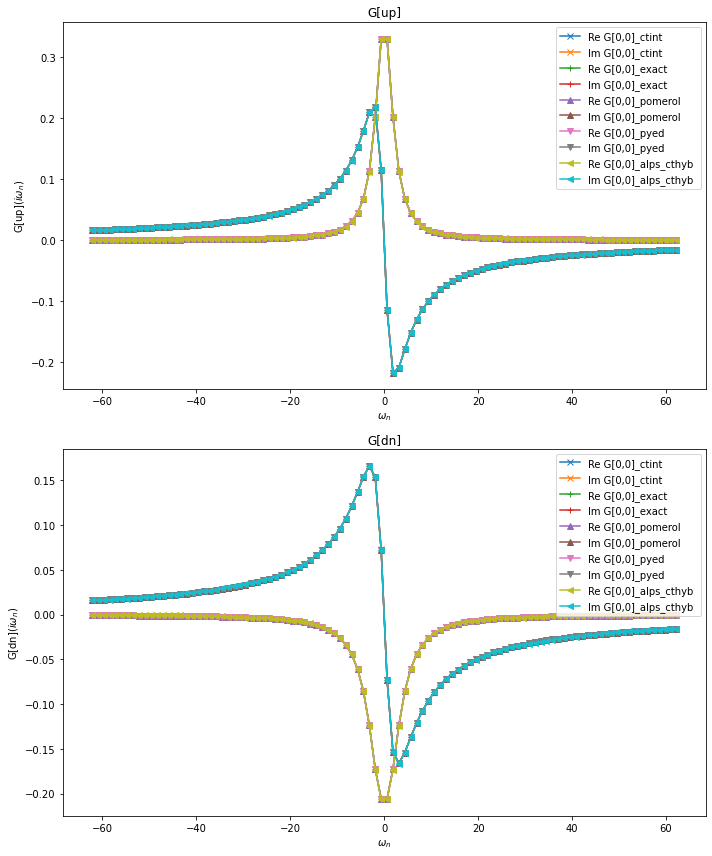

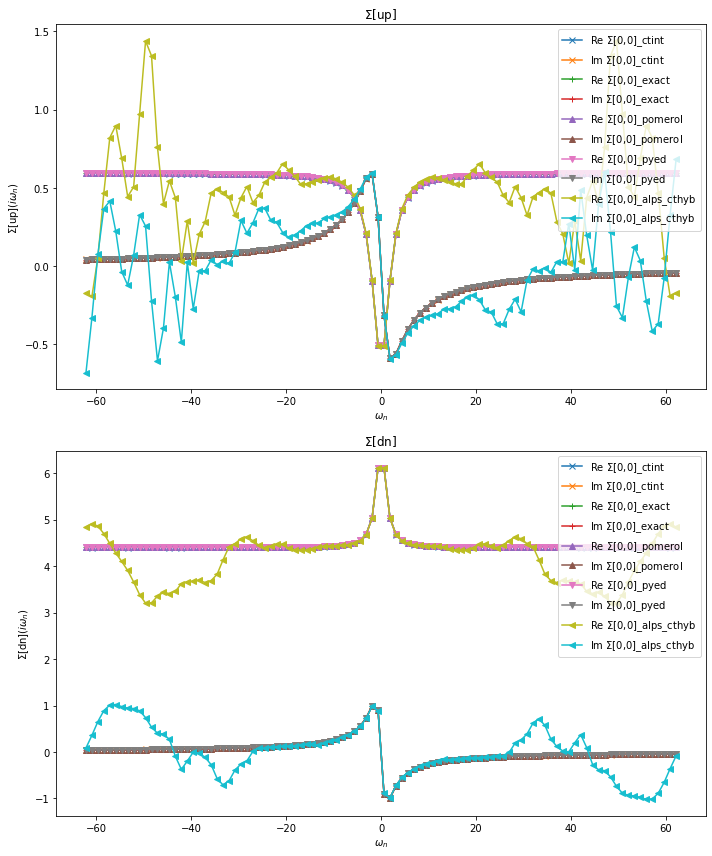

In [3]:
# %load ../common/plot.py
import sys, os
sys.path.append(os.getcwd() + "/..")
sys.path.append(os.getcwd() + "/../../common")
from model import *

from h5 import HDFArchive
from triqs.plot.mpl_interface import oplot, plt
from glob import glob
from os.path import basename

# === Load Green function for every solver and calculate self-energy

solver_lst = [ basename(f).strip('.h5') for f in glob('results/*.h5') ]
marker_lst = ['-x', '-+', '-^', '-v', '-<', '->']
G, Sigma = {}, {}

for solver in solver_lst:
    dat = HDFArchive('results/' + solver + '.h5','r')
    G[solver] = dat['G']
    Sigma[solver] = G0_iw.copy()
    Sigma[solver] << inverse(G0_iw) - inverse(G[solver])

# === For every block and solver, plot Green function and Self energy

block_lst = list(G[solver_lst[0]].indices)
n_blocks = len(block_lst)

for g, name in [[G, 'G'], [Sigma, '$\Sigma$']]:

    plt.subplots(n_blocks,1,figsize=(10,6*n_blocks))

    for i, block in enumerate(block_lst,1):
        fig = plt.subplot(n_blocks,1,i)
        fig.set_title(name + "[" + block + "]")
        for solver in solver_lst:
            marker = marker_lst[solver_lst.index(solver)]
            oplot(g[solver][block][0,0], marker, name = name + "[0,0]_%s" % solver)
        plt.xlabel("$\omega_n$")
        plt.ylabel(name + "[" + block + "]$(i\omega_n)$")

    plt.tight_layout()
    plt.show()


Deviations
======

We present a table containing deviations between the different solvers measured via

$$||G_{\rm Solver_1} - G_{\rm Solver_2}||_\infty$$

In [4]:
import numpy as np

norm_inf = lambda G : np.amax(np.abs(G.data))

for block in block_lst:
    deviations = [[ norm_inf(G[s1][block] - G[s2][block]) for s1 in solver_lst ] \
                    for s2 in solver_lst ]
    
    print("\t\t    Deviations for Block " + block)
    print("\t\t -----------------------------------")

    row_format ="{:>15}" * (len(solver_lst) + 1)
    print(row_format.format("", *solver_lst))
    row_format ="{:>15}" + "{:>15.2E}" * len(solver_lst)
    for solver, row in zip(solver_lst, deviations):
        print(row_format.format(solver, *row))
        
    print("\n\n")

		    Deviations for Block up
		 -----------------------------------
                         ctint          exact        pomerol           pyed     alps_cthyb
          ctint       0.00E+00       1.49E-04       1.49E-04       1.49E-04       7.40E-04
          exact       1.49E-04       0.00E+00       1.14E-16       7.85E-17       7.34E-04
        pomerol       1.49E-04       1.14E-16       0.00E+00       1.12E-16       7.34E-04
           pyed       1.49E-04       7.85E-17       1.12E-16       0.00E+00       7.34E-04
     alps_cthyb       7.40E-04       7.34E-04       7.34E-04       7.34E-04       0.00E+00



		    Deviations for Block dn
		 -----------------------------------
                         ctint          exact        pomerol           pyed     alps_cthyb
          ctint       0.00E+00       4.35E-04       4.35E-04       4.35E-04       8.24E-04
          exact       4.35E-04       0.00E+00       2.24E-16       1.96E-16       7.64E-04
        pomerol       4.35E-04       2.2